### Rice Image Dataset Classification

In this notebook, we'll explore the Rice Image Dataset and build a classifier to classify rice images into different classes. Let's start by importing necessary libraries and exploring the dataset.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

import pathlib
import zipfile
import requests
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

### Load the rice image dataset and preprocessing 


Before we proceed further, let's list the classes present in the Rice Image Dataset. This will give us an overview of the different categories of rice images we'll be working with.


In [2]:
dataset_dir = '../input/rice-image-dataset/Rice_Image_Dataset/'
class_names = sorted(os.listdir(dataset_dir))[:-1]
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [3]:
def download_dataset(url, filename):
    response = requests.get(url)
    if response == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
            return True
    else:
        return False


def unzip_file(file_name, location):
    with zipfile.ZipFile(file_name, location) as f:
        f.extractall(location)


def check_file_exists(directory_path) -> bool:
    return os.path.exists(directory_path)


def print_number_of_files(data_dir):

    Arborio = list(data_dir.glob("Arborio/*"))
    Basmati = list(data_dir.glob("Basmati/*"))
    Ipsala = list(data_dir.glob("Ipsala/*"))
    Jasmine = list(data_dir.glob("Jasmine/*"))
    Karacadag = list(data_dir.glob("Karacadag/*"))

    print("The length of Arborio: %d" % len(Arborio))
    print("The length of Jasmine: %d" % len(Jasmine))
    print("The length of Basmati: %d" % len(Basmati))
    print("The length of Ipsala: %d" % len(Ipsala))
    print("The length of Karacadag: %d" % len(Karacadag))


def get_image_files(dir_path):
    all_image_dirs = [f.path for f in os.scandir(dir_path) if f.is_dir()]
    for dir in all_image_dirs:
        for img in os.listdir(dir):
            yield os.path.join(dir, img)


def get_image_size(image_path) -> tuple:
    image = Image.open(image_path)
    return image.size


def check_image_size(image_path, actual_width, actual_height) -> bool:
    width, height = get_image_size(image_path)
    if actual_width is width and actual_height is height:
        return True
    else:
        return False


def resize_image(image_path, target_size=(250, 250)):
    image = Image.open(image_path)
    resized_image = image.resize(target_size)
    resized_image.save(image_path)
    print(f'Resized image "{image_path}" to {target_size}.')


def resize_if_required(data_dir, actual_width, actual_height):
    with ThreadPoolExecutor(max_workers=8) as executor:
        for img in get_image_files(data_dir):
            result = executor.submit(check_image_size, img, actual_width, actual_height)
            if not result:
                resize_image(img)

# preproccessing
data_dir = pathlib.Path(dataset_dir).absolute()
first_image = next(get_image_files(data_dir))
print_number_of_files(data_dir)
actual_width, actual_height = get_image_size(first_image)
resize_if_required(dataset_dir, actual_width, actual_height)


The length of Arborio: 15000
The length of Jasmine: 15000
The length of Basmati: 15000
The length of Ipsala: 15000
The length of Karacadag: 15000


In [4]:
name_class = os.listdir('../input/rice-image-dataset/Rice_Image_Dataset/')
name_class

['Karacadag',
 'Basmati',
 'Jasmine',
 'Rice_Citation_Request.txt',
 'Arborio',
 'Ipsala']

### Preparing Image Filenames

Before we proceed further with our analysis or processing of the Rice Image Dataset, we first need to prepare a list of image filenames. This list will be essential for loading and working with the images in subsequent steps.


In [5]:
image_filenames = os.listdir(dataset_dir)
filename_to_remove = 'Rice_Citation_Request.txt'
if filename_to_remove in image_filenames:
    image_filenames.remove(filename_to_remove)
    print(f"{filename_to_remove} removed from the list.")
else:
    print(f"{filename_to_remove} not found in the list.")
    print("Updated list of filenames:", image_filenames)

Rice_Citation_Request.txt removed from the list.


### Preparing Training and Test Sets

In this section, we'll prepare the training and test sets using the image filenames obtained from the Rice Image Dataset directory. This involves iterating through the subfolders, collecting filenames, and shuffling them to ensure randomness in the distribution of classes between the training and test sets. We'll also print the sizes and class distributions of both sets to get an overview of the data distribution.


In [6]:
all_image_filenames = []
all_labels = []

for subfolder in image_filenames:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    for filename in os.listdir(subfolder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            all_image_filenames.append(os.path.join(subfolder_path, filename))
            all_labels.append(subfolder)

combined = list(zip(all_image_filenames, all_labels))

np.random.shuffle(combined)
all_image_filenames[:], all_labels[:] = zip(*combined)

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(
    all_image_filenames, all_labels, test_size=0.2, random_state=42)


print("Size of training set:", len(X_train_filenames))
print("Size of test set:", len(X_test_filenames))

train_class_distribution = Counter(y_train)
print("Class distribution in training set:", train_class_distribution)

test_class_distribution = Counter(y_test)
print("Class distribution in test set:", test_class_distribution)

Size of training set: 60000
Size of test set: 15000
Class distribution in training set: Counter({'Karacadag': 12043, 'Jasmine': 12025, 'Ipsala': 12002, 'Arborio': 11985, 'Basmati': 11945})
Class distribution in test set: Counter({'Basmati': 3055, 'Arborio': 3015, 'Ipsala': 2998, 'Jasmine': 2975, 'Karacadag': 2957})


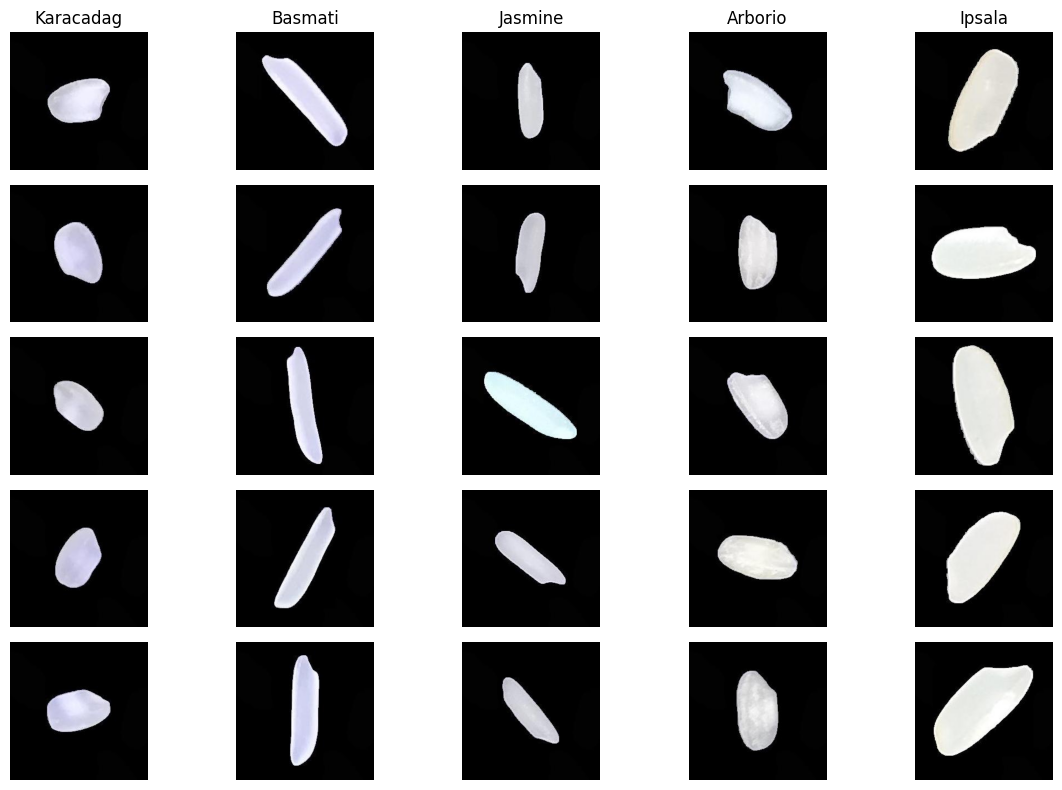

In [7]:
classes = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']
num_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(12, 8))
for y, cls in enumerate(classes):
    idxs = [idx for idx, label in enumerate(y_train) if label == cls]
    if len(idxs) == 0:
        print(f"No samples available for class {cls}")
        continue
    idxs = np.random.choice(idxs, min(samples_per_class, len(idxs)), replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        image = plt.imread(X_train_filenames[idx])
        plt.imshow(image)
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.tight_layout()
plt.show()

# Data Subsampling and Preprocessing

In this section, we'll subsample the data to make the code execution more efficient. Specifically, we'll sample 5000 data points from the training set and 500 data points from the test set to speed up the processing time.

After subsampling, we'll load the images from the file paths, resize them to 32x32 pixels, and extract labels from the filenames. Additionally, we'll define the classes based on the rice types present in the dataset.

Let's proceed with subsampling the data and preparing it for further processing.


In [8]:
def load_images(image_filenames):
    """Load images from file paths and resize them to 32x32."""
    images = []
    for filename in image_filenames:
        image = io.imread(filename)
        image = transform.resize(image, (32, 32), anti_aliasing=True)
        images.append(image)
    return np.array(images)

def load_labels(image_filenames):
    """Extract labels from image filenames."""
    return [os.path.basename(os.path.dirname(filename)) for filename in image_filenames]

# Load CIFAR-10 data from images
def load_data_from_images(X_filenames,  limit=None):
    if limit is not None:
        X_filenames = X_filenames[:limit]
    X = load_images(X_filenames)
    y = load_labels(X_filenames)
    return X, y

classes = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

limit = 1000  # Limit to 10 training images for testing
X_train, y_train = load_data_from_images(X_train_filenames, limit=limit)
X_test, y_test = load_data_from_images(X_test_filenames, limit=limit)


X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)


# Training and Evaluation of kNN Classifier

In this section, we'll train a kNN (k-Nearest Neighbors) classifier using the subsampled training data. We'll use an example value of k=3 for the kNN classifier.

After training the classifier, we'll evaluate its performance on the subsampled test data. We'll calculate the accuracy of the classifier and generate a classification report to provide insights into its performance across different classes.

Let's proceed with training the kNN classifier and evaluating its performance.


In [9]:
k = 3  
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_flatten, y_train)

y_pred = knn_classifier.predict(X_test_flatten)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

   Karacadag       0.95      0.88      0.91       201
     Basmati       0.92      0.97      0.94       209
     Jasmine       1.00      0.97      0.98       207
     Arborio       0.93      0.90      0.91       192
      Ipsala       0.90      0.98      0.94       191

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



# Visualization of Performance Metrics by Class

In this section, we'll visualize the precision, recall, and F1-score of the kNN classifier for each class. These metrics provide insights into the classifier's performance across different classes, allowing us to identify any class-specific performance variations.

Let's proceed with visualizing the performance metrics by class.


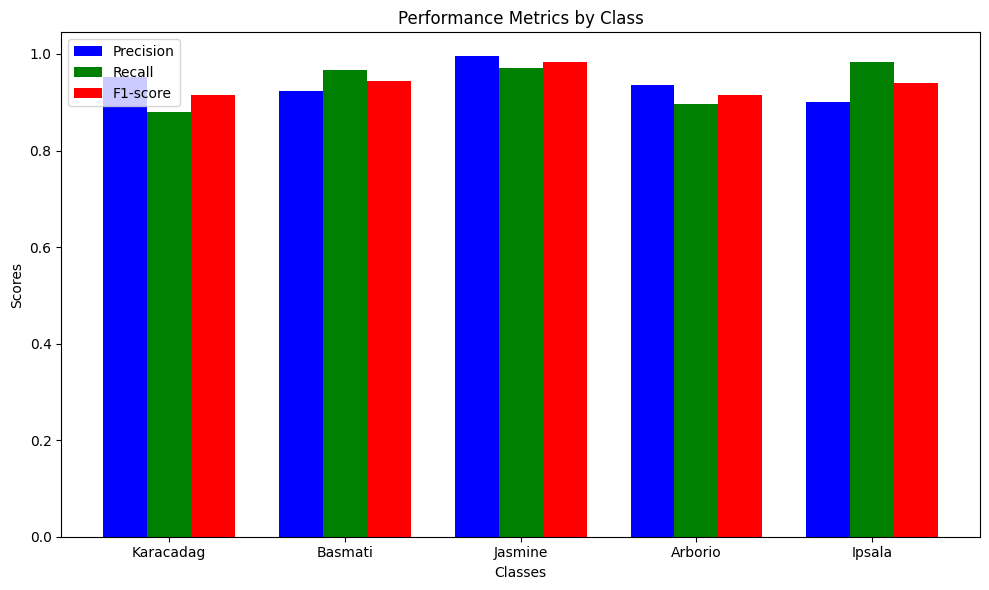

In [10]:
report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
bar_width = 0.25

plt.bar(x, precision, width=bar_width, color='b', align='center', label='Precision')
plt.bar(x + bar_width, recall, width=bar_width, color='g', align='center', label='Recall')
plt.bar(x + 2*bar_width, f1_score, width=bar_width, color='r', align='center', label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Performance Metrics by Class')
plt.xticks(x + bar_width, classes)
plt.legend()
plt.tight_layout()
plt.show()